## ERM ##


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Function
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

In [2]:
data_set = "PACS/PACS"
train_domain = "photo"
test_domain = "art_painting"

# ## visualise 10 samples from the training domain ##
# for cls in os.listdir(os.path.join(data_set, train_domain)):
#     cls_path = os.path.join(data_set, train_domain, cls)
#     sample_images = random.sample(os.listdir(cls_path), 10)
#     images = []
#     for img_name in sample_images:
#         img_path = os.path.join(cls_path, img_name)
#         image = Image.open(img_path).convert('RGB')
#         images.append(transforms.ToTensor()(image))
#     grid_img = make_grid(images, nrow=5)
#     plt.figure(figsize=(12,6))
#     plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
#     plt.title(f"Class: {cls} from domain: {train_domain}")
#     plt.axis('off')
#     plt.show()

# ## visualise 10 samples from the testing domain ##
# for cls in os.listdir(os.path.join(data_set, test_domain)):
#     cls_path = os.path.join(data_set, test_domain, cls)
#     sample_images = random.sample(os.listdir(cls_path), 10)
#     images = []
#     for img_name in sample_images:
#         img_path = os.path.join(cls_path, img_name)
#         image = Image.open(img_path).convert('RGB')
#         images.append(transforms.ToTensor()(image))
#     grid_img = make_grid(images, nrow=5)
#     plt.figure(figsize=(12,6))
#     plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
#     plt.title(f"Class: {cls} from domain: {test_domain}")
#     plt.axis('off')
#     plt.show()




In [33]:
def _infer_class_names_from_loader(loader, num_classes=None):
    ds = getattr(loader, "dataset", None)
    if ds is not None:
        # First check if dataset has classes directly (ImageFolder case)
        if hasattr(ds, "classes"):
            return list(ds.classes)
        # If it's a Subset (from random_split), look into the underlying dataset
        elif hasattr(ds, "dataset") and hasattr(ds.dataset, "classes"):
            return list(ds.dataset.classes)
    
    if num_classes is None:
        raise ValueError("num_classes is required when class names cannot be inferred.")
    return [str(i) for i in range(num_classes)]

def _to_device(model, device):
    if isinstance(device, str):
        device = torch.device(device)
    return model.to(device), device

In [34]:
# ---------- 1) Evaluation + sklearn reports ----------
@torch.no_grad()
def evaluate_with_reports(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device | str = "cuda",
    criterion: torch.nn.Module | None = None,
    class_names: list[str] | None = None,
    num_classes: int | None = None,
    desc: str = "Eval",
    show_plots: bool = True,
    save_dir: str | None = None,
    save_prefix: str | None = None,
):
    """
    Runs forward pass, computes loss/acc, prints sklearn classification report,
    and plots confusion matrices (counts + row-normalized).
    Returns dict with metrics and arrays.
    """
    model, device = _to_device(model.eval(), device)
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    pbar = tqdm(loader, desc=desc, leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(images)
        # Handle case where model returns tuple (e.g., DANN model)
        if isinstance(outputs, tuple):
            logits = outputs[0]  # First element is class logits
        else:
            logits = outputs
            
        loss = criterion(logits, targets)
        preds = torch.argmax(logits, dim=1)

        running_loss += loss.item() * images.size(0)
        correct += (preds == targets).sum().item()
        total += images.size(0)

        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())

        pbar.set_postfix({"loss": f"{running_loss/total:.4f}",
                          "acc": f"{100.0*correct/total:.2f}%"})

    loss = running_loss / total
    acc = 100.0 * correct / total
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    if class_names is None:
        class_names = _infer_class_names_from_loader(loader, num_classes)
    C = len(class_names)

    # sklearn report + confusion matrices
    print(f"\n=== {desc} Results ===")
    print(f"Loss: {loss:.4f} | Acc: {acc:.2f}%\n")

    report_txt = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report_txt)

    cm = confusion_matrix(y_true, y_pred, labels=range(C))
    cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

    def _maybe_save(fig, name):
        if save_dir and save_prefix:
            # Create directory if it doesn't exist
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{save_prefix}_{name}.png")
            fig.savefig(save_path, dpi=200, bbox_inches="tight")
            print(f"Saved: {save_path}")

    if show_plots:
        fig = plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix (Counts) — {desc}")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
        _maybe_save(fig, "cm_counts")
        plt.show()

        fig = plt.figure(figsize=(8,6))
        sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names, vmin=0.0, vmax=1.0)
        plt.title(f"Confusion Matrix (Row-Normalized) — {desc}")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
        _maybe_save(fig, "cm_row_norm")
        plt.show()

    return {
        "loss": loss, "acc": acc,
        "y_true": y_true, "y_pred": y_pred,
        "cm": cm, "cm_row_norm": cm_norm,
        "report": report_txt, "class_names": class_names
    }

In [35]:
@torch.no_grad()
def tsne_penultimate_features(
    model: torch.nn.Module,
    loaders: dict[str, torch.utils.data.DataLoader],
    # e.g., {"photo_train": train_loader, "photo_val": val_loader, "art_painting": test_loader}
    device: torch.device | str = "cuda",
    layer_name: str = "avgpool",
    max_per_split: int | None = None,
    perplexity: float = 30.0,
    random_state: int = 42,
    n_iter: int = 1000,
    class_names: list[str] | None = None,
    num_classes: int | None = None,
    show_plot: bool = True,
    save_dir: str | None = None,
    save_filename: str = "tsne_features.png",
):
    """
    Extracts penultimate features from each provided loader, runs 2D t-SNE, and plots
    with color=class and marker=domain (split key).
    """
    model, device = _to_device(model.eval(), device)
    
    # Check if model has a backbone attribute (DANN-style) or use the model directly
    if hasattr(model, 'backbone'):
        feat_extractor = create_feature_extractor(model.backbone, return_nodes={layer_name: "feat"})
    else:
        feat_extractor = create_feature_extractor(model, return_nodes={layer_name: "feat"})

    def collect(loader, split_key):
        feats, labels = [], []
        seen = 0
        for images, targets in tqdm(loader, desc=f"Feats: {split_key}", leave=False):
            images = images.to(device, non_blocking=True)
            f = feat_extractor(images)["feat"]
            f = torch.flatten(f, 1).cpu()  # [B, D]
            feats.append(f); labels.append(targets.cpu())
            seen += images.size(0)
            if max_per_split and seen >= max_per_split:
                break
        feats = torch.cat(feats, 0).numpy()
        labels = torch.cat(labels, 0).numpy()
        domains = np.array([split_key] * feats.shape[0])
        return feats, labels, domains

    # collect all
    all_feats, all_labels, all_domains = [], [], []
    for split_key, loader in loaders.items():
        f, l, d = collect(loader, split_key)
        all_feats.append(f); all_labels.append(l); all_domains.append(d)

    X = np.vstack(all_feats)
    y = np.concatenate(all_labels)
    d = np.concatenate(all_domains)

    if class_names is None:
        # infer from any loader
        some_loader = next(iter(loaders.values()))
        class_names = _infer_class_names_from_loader(some_loader, num_classes)
    C = len(class_names)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto",
                init="pca", random_state=random_state, n_iter=n_iter, verbose=1)
    Z = tsne.fit_transform(X)

    # plot
    if show_plot:
        plt.figure(figsize=(10, 8))
        colors = plt.cm.get_cmap('tab10', C)
        markers = {k: m for k, m in zip(loaders.keys(), ["o", "s", "^", "D", "v", "P", "X"])}

        for c_idx, cname in enumerate(class_names):
            color = colors(c_idx)
            for dom, marker in markers.items():
                mask = (y == c_idx) & (d == dom)
                plt.scatter(Z[mask, 0], Z[mask, 1], s=18, marker=marker,
                            edgecolors='none', alpha=0.8, c=[color])

        plt.title("t-SNE of Penultimate Features — Color: Class, Marker: Domain")
        plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")

        class_handles = [Line2D([0], [0], marker='o', color=colors(i),
                                linestyle='None', markersize=8, label=class_names[i])
                         for i in range(C)]
        domain_handles = [Line2D([0], [0], marker=m, color='k',
                                 linestyle='None', markersize=8, label=k)
                          for k, m in markers.items()]

        leg1 = plt.legend(handles=class_handles, title="Classes",
                          loc="upper right", bbox_to_anchor=(1.35, 1.0))
        plt.gca().add_artist(leg1)
        plt.legend(handles=domain_handles, title="Domains",
                   loc="lower right", bbox_to_anchor=(1.35, 0.0))
        plt.tight_layout()
        
        # Save to directory if specified
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, save_filename)
            plt.savefig(save_path, dpi=200, bbox_inches="tight")
            print(f"Saved: {save_path}")
        
        plt.show()

    return {"Z": Z, "y": y, "domains": d, "class_names": class_names}

In [36]:
def plot_class_distribution_shift(
    source_loader: torch.utils.data.DataLoader,
    target_loader: torch.utils.data.DataLoader,
    class_names: list[str] | None = None,
    num_classes: int | None = None,
    title: str = "Class Distribution Shift (P_target − P_source)",
    show_plot: bool = True,
    save_dir: str | None = None,
    save_filename: str = "class_distribution_shift.png",
):
    """
    Computes p_source(y), p_target(y), and plots a 1×C heatmap of (target − source).
    Returns dict with counts and distributions.
    """
    if class_names is None:
        class_names = _infer_class_names_from_loader(target_loader, num_classes)
    C = len(class_names)

    # Count labels directly from datasets (no forward pass)
    src_counts = np.bincount([y for _, y in source_loader.dataset], minlength=C)
    tgt_counts = np.bincount([y for _, y in target_loader.dataset], minlength=C)

    src_dist = src_counts / src_counts.sum()
    tgt_dist = tgt_counts / tgt_counts.sum()
    diff = tgt_dist - src_dist

    if show_plot:
        plt.figure(figsize=(8, 3))
        sns.heatmap([diff], annot=True, cmap="coolwarm", center=0,
                    xticklabels=class_names, yticklabels=["target − source"])
        plt.title(title); plt.xlabel("Class")
        plt.tight_layout()
        
        # Save to directory if specified
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, save_filename)
            plt.savefig(save_path, dpi=200, bbox_inches="tight")
            print(f"Saved: {save_path}")
        
        plt.show()

    return {
        "src_counts": src_counts, "tgt_counts": tgt_counts,
        "src_dist": src_dist, "tgt_dist": tgt_dist, "diff": diff,
        "class_names": class_names
    }

In [24]:

# Load ResNet-50 pretrained on ImageNet #
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

for param in model.parameters():
    param.requires_grad = True

model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
### Creating train / val splits for the photo domain ###
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Base dataset path
data_set = "PACS/PACS"

# Domains
train_domain = "photo"
val_domain = "art_painting"

# Image transformations (standard ImageNet normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 1. Load the Photo domain (for train/val split)
photo_dataset = datasets.ImageFolder(os.path.join(data_set, train_domain),
                                     transform=transform)

# Create train/val split (e.g., 80/20)
val_split = 0.2
train_size = int((1 - val_split) * len(photo_dataset))
val_size = len(photo_dataset) - train_size

erm_photo_train, erm_photo_val = random_split(
    photo_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# 2. Load the entire Art Painting domain as validation/test set
erm_art_painting_val = datasets.ImageFolder(os.path.join(data_set, val_domain),
                                            transform=transform)

# 3. (Optional) Create DataLoaders
erm_train_loader = DataLoader(erm_photo_train, batch_size=32, shuffle=True)
erm_val_loader = DataLoader(erm_photo_val, batch_size=32, shuffle=False)
art_painting_loader = DataLoader(erm_art_painting_val, batch_size=32, shuffle=False)

print(f"Photo Train: {len(erm_photo_train)} images")
print(f"Photo Val: {len(erm_photo_val)} images")
print(f"Art Painting Val: {len(erm_art_painting_val)} images")


Photo Train: 1336 images
Photo Val: 334 images
Art Painting Val: 2048 images


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----- Loss & Optimizer -----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ----- (Optional) Reproducibility -----
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ----- One epoch of training -----
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Train]", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            running_correct += (preds == targets).sum().item()
            total += images.size(0)

        pbar.set_postfix({
            "loss": f"{running_loss/total:.4f}",
            "acc": f"{100.0*running_correct/total:.2f}%"
        })

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * running_correct / total
    return epoch_loss, epoch_acc

# ----- One epoch of evaluation -----
@torch.no_grad()
def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Val]  ", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * images.size(0)
        running_correct += (preds == targets).sum().item()
        total += images.size(0)

        pbar.set_postfix({
            "loss": f"{running_loss/total:.4f}",
            "acc": f"{100.0*running_correct/total:.2f}%"
        })

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * running_correct / total
    return epoch_loss, epoch_acc

# ----- Training loop -----
num_epochs = 10
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, erm_train_loader, optimizer, criterion, device, epoch)
    val_loss, val_acc = evaluate(model, erm_val_loader, criterion, device, epoch)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # (Optional) save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "resnet50_pacs_best.pt")

print(f"Best Val Acc: {best_val_acc:.2f}%")

Epoch 01 | Train Loss: 0.7922 | Train Acc: 86.90% || Val Loss: 0.0836 | Val Acc: 97.90%


Epoch 02 | Train Loss: 0.0569 | Train Acc: 98.95% || Val Loss: 0.0301 | Val Acc: 99.70%


Epoch 03 | Train Loss: 0.0201 | Train Acc: 99.63% || Val Loss: 0.0176 | Val Acc: 99.70%


Epoch 04 | Train Loss: 0.0105 | Train Acc: 99.78% || Val Loss: 0.0282 | Val Acc: 98.80%


Epoch 05 | Train Loss: 0.0089 | Train Acc: 99.85% || Val Loss: 0.0157 | Val Acc: 99.10%


Epoch 06 | Train Loss: 0.0054 | Train Acc: 99.93% || Val Loss: 0.0359 | Val Acc: 98.20%


Epoch 07 | Train Loss: 0.0038 | Train Acc: 100.00% || Val Loss: 0.0242 | Val Acc: 98.80%


Epoch 08 | Train Loss: 0.0040 | Train Acc: 99.93% || Val Loss: 0.0214 | Val Acc: 99.10%


Epoch 09 | Train Loss: 0.0126 | Train Acc: 99.48% || Val Loss: 0.0314 | Val Acc: 99.10%


Epoch 10 | Train Loss: 0.0081 | Train Acc: 99.85% || Val Loss: 0.0267 | Val Acc: 98.80%
Best Val Acc: 99.70%



=== OOD [art_painting] Results ===
Loss: 1.0962 | Acc: 63.77%

              precision    recall  f1-score   support

         dog     0.8024    0.7071    0.7518       379
    elephant     0.7231    0.6863    0.7042       255
     giraffe     0.7500    0.6632    0.7039       285
      guitar     0.3606    0.9837    0.5277       184
       horse     0.4354    0.8557    0.5772       201
       house     0.9916    0.7966    0.8835       295
      person     1.0000    0.1915    0.3215       449

    accuracy                         0.6377      2048
   macro avg     0.7233    0.6977    0.6385      2048
weighted avg     0.7801    0.6377    0.6266      2048



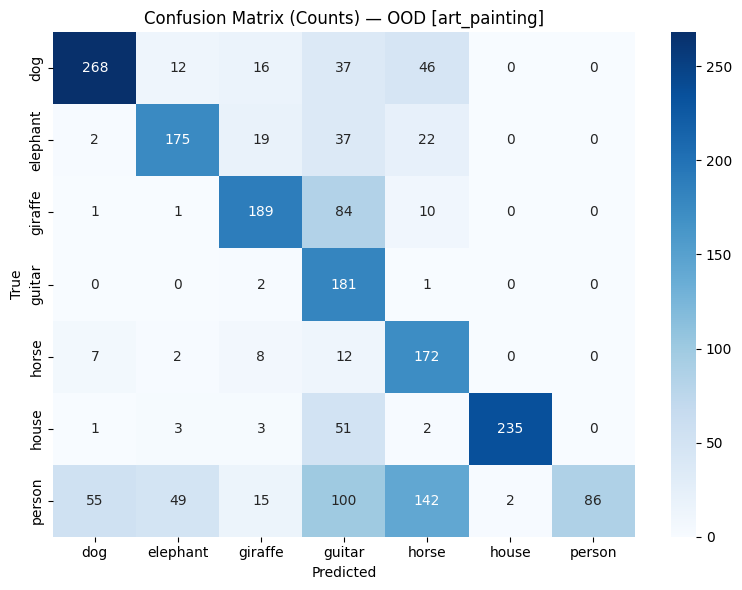

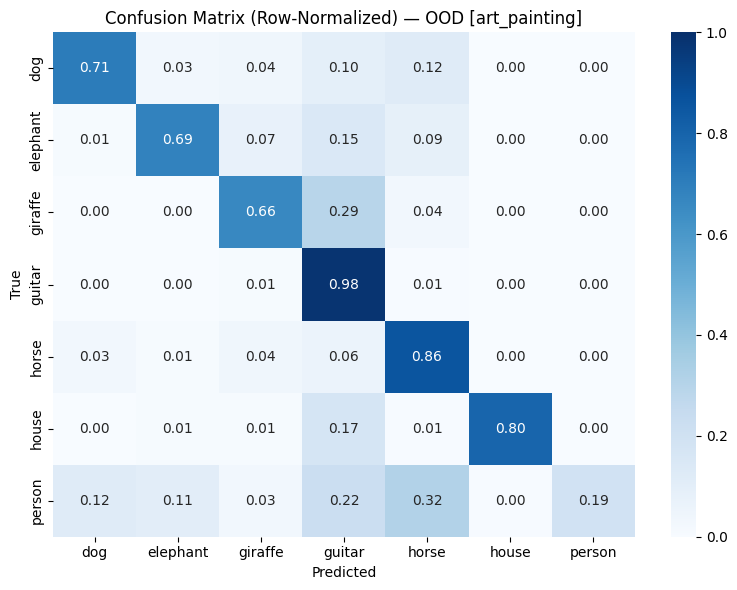

/home/csalt/anaconda3/envs/allm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3718 samples in 0.002s...
[t-SNE] Computed neighbors for 3718 samples in 0.309s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3718
[t-SNE] Computed conditional probabilities for sample 2000 / 3718
[t-SNE] Computed conditional probabilities for sample 3000 / 3718
[t-SNE] Computed conditional probabilities for sample 3718 / 3718
[t-SNE] Mean sigma: 5.311134
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.679909
[t-SNE] KL divergence after 1000 iterations: 1.206706


/tmp/ipykernel_1717659/3297945949.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', C)


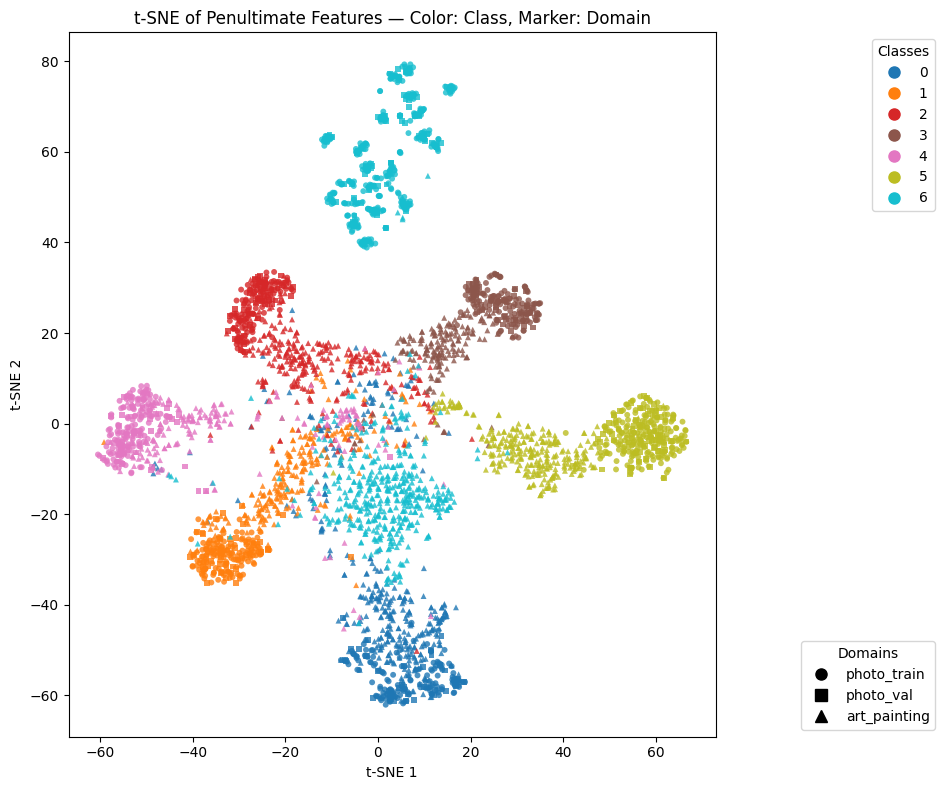

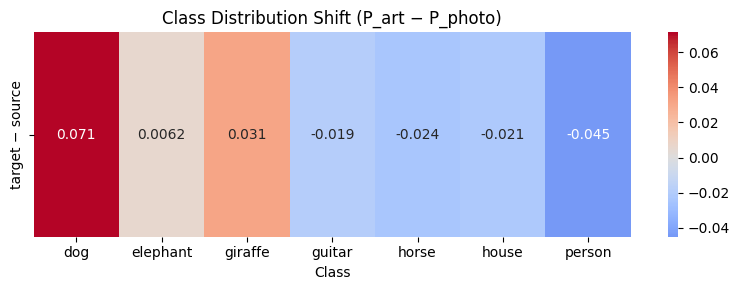

In [19]:
# 1) OOD evaluation on art_painting
eval_art = evaluate_with_reports(
    model, art_painting_loader, device="cuda",
    desc="OOD [art_painting]", show_plots=True, save_prefix="ood_art"
)

# 2) t-SNE across photo_train, photo_val, art_painting
tsne_out = tsne_penultimate_features(
    model,
    num_classes=7,
    loaders={
        "photo_train": erm_train_loader,
        "photo_val":   erm_val_loader,
        "art_painting": art_painting_loader
    },
    device="cuda",
    max_per_split=None,   # or an int for speed
    save_path="tsne_pacs.png"
)

# 3) Class-distribution shift: photo_train vs art_painting
shift = plot_class_distribution_shift(
    source_loader=erm_train_loader,
    target_loader=art_painting_loader,
    title="Class Distribution Shift (P_art − P_photo)",
    save_path="shift_art_minus_photo.png"
)



## DANN ##

In [26]:
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

def grad_reverse(x, alpha=1.0):
    return GradReverse.apply(x, alpha)

class DANN(nn.Module):
    def __init__(self, num_classes=7, disc_hidden=1024, backbone_weights=models.ResNet50_Weights.IMAGENET1K_V2):
        super().__init__()
        # Backbone
        self.backbone = models.resnet50(weights=backbone_weights)
        in_dim = self.backbone.fc.in_features

        # Replace fc by identity to expose penultimate features (2048-D)
        self.backbone.fc = nn.Identity()

        # Label classifier head (7-way)
        self.classifier = nn.Linear(in_dim, num_classes)

        # Domain discriminator (binary)
        self.domain_discriminator = nn.Sequential(
            nn.Linear(in_dim, disc_hidden), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(disc_hidden, disc_hidden), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(disc_hidden, 1)  # logits; use BCEWithLogitsLoss
        )

    def forward(self, x, alpha=0.0):
        """
        alpha controls the GRL strength (0 => no reversal; 1 => full).
        Returns: class_logits, domain_logits, features
        """
        feats = self.backbone(x)                # [B, 2048]
        class_logits = self.classifier(feats)   # [B, 7]

        rev_feats = grad_reverse(feats, alpha)  # GRL
        domain_logits = self.domain_discriminator(rev_feats)  # [B, 1] logits

        return class_logits, domain_logits, feats







In [47]:
dataset_root = "PACS/PACS"
in_domain = "photo"
out_domain = "art_painting"
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Labeled source (in-domain)
photo_full = datasets.ImageFolder(os.path.join(dataset_root, in_domain), transform=transform)

# Unlabeled target (out-domain)
art_full = datasets.ImageFolder(os.path.join(dataset_root, out_domain), transform=transform)

In [48]:
def split_dataset(full_dataset, val_ratio=0.2, seed=42):
    n_total = len(full_dataset)
    n_val = int(val_ratio * n_total)
    n_train = n_total - n_val
    train_set, val_set = random_split(
        full_dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(seed)
    )
    return train_set, val_set

photo_train, photo_val = split_dataset(photo_full, val_ratio=0.2)
art_train, art_val = split_dataset(art_full, val_ratio=0.2)


batch_size = 64
photo_train_loader = DataLoader(photo_train, batch_size=batch_size, shuffle=True, num_workers=4)
photo_val_loader   = DataLoader(photo_val,   batch_size=batch_size, shuffle=False, num_workers=4)
art_train_loader   = DataLoader(art_train,   batch_size=batch_size, shuffle=True, num_workers=4)
art_val_loader     = DataLoader(art_val,     batch_size=batch_size, shuffle=False, num_workers=4)


print(f"Photo: train={len(photo_train)}, val={len(photo_val)}")
print(f"Art:   train={len(art_train)}, val={len(art_val)}")



Photo: train=1336, val=334
Art:   train=1639, val=409


In [29]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from itertools import islice
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DANN(num_classes=7).to(device)

# Losses
ce  = nn.CrossEntropyLoss()        # source label loss
bce = nn.BCEWithLogitsLoss()       # domain loss (binary)

# Optimizer
optimizer = optim.Adam([
    {"params": model.backbone.parameters(),           "lr": 1e-4},
    {"params": model.classifier.parameters(),         "lr": 1e-4},
    {"params": model.domain_discriminator.parameters(),"lr": 1e-4},
])

# Ganin GRL scheduling helper (0 -> 1 over training)
def grl_alpha(progress: float) -> float:
    # progress in [0,1]
    return 2.0 / (1.0 + math.exp(-10.0 * progress)) - 1.0

lambda_d = 0.2
epochs   = 20

@torch.no_grad()
def evaluate_cls(model, loader, desc):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits, _, _ = model(x, alpha=0.0)  # no GRL in eval
        loss = ce(logits, y)
        pred = logits.argmax(1)
        total_loss += loss.item() * x.size(0)
        correct    += (pred == y).sum().item()
        total      += x.size(0)
    return total_loss / total, 100.0 * correct / total

# ===== Track best model =====
best_art_acc = 0.0
save_path = os.path.join(os.getcwd(), "DANN_photo2art.pth")

for epoch in range(1, epochs + 1):
    model.train()
    running = {"cls": 0.0, "dom": 0.0, "total": 0.0}
    seen = 0

    steps_per_epoch = max(len(photo_train_loader), len(art_train_loader))
    src_iter = iter(photo_train_loader)
    tgt_iter = iter(art_train_loader)

    pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch:02d} [Train]")
    for step in pbar:
        try:
            xs, ys = next(src_iter)
        except StopIteration:
            src_iter = iter(photo_train_loader)
            xs, ys = next(src_iter)

        try:
            xt, _ = next(tgt_iter)
        except StopIteration:
            tgt_iter = iter(art_train_loader)
            xt, _ = next(tgt_iter)

        xs = xs.to(device, non_blocking=True)
        ys = ys.to(device, non_blocking=True)
        xt = xt.to(device, non_blocking=True)

        global_step = (epoch - 1) * steps_per_epoch + step
        total_steps = epochs * steps_per_epoch
        alpha = grl_alpha(global_step / max(1, total_steps - 1))

        # Forward passes
        src_cls_logits, src_dom_logits, _ = model(xs, alpha=alpha)
        _, tgt_dom_logits, _ = model(xt, alpha=alpha)

        # Losses
        loss_cls = ce(src_cls_logits, ys)
        src_dom_t = torch.zeros_like(src_dom_logits)
        tgt_dom_t = torch.ones_like(tgt_dom_logits)

        loss_dom_src = bce(src_dom_logits, src_dom_t)
        loss_dom_tgt = bce(tgt_dom_logits, tgt_dom_t)
        loss_dom = 0.5 * (loss_dom_src + loss_dom_tgt)

        loss = loss_cls + lambda_d * loss_dom

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bs = xs.size(0)
        running["cls"]   += loss_cls.item() * bs
        running["dom"]   += loss_dom.item() * bs
        running["total"] += loss.item()     * bs
        seen += bs

        pbar.set_postfix({
            "CE":   f"{running['cls']/seen:.4f}",
            "Dom":  f"{running['dom']/seen:.4f}",
            "Tot":  f"{running['total']/seen:.4f}",
            "α":    f"{alpha:.2f}"
        })

    # ===== Validation =====
    photo_val_loss, photo_val_acc = evaluate_cls(model, photo_val_loader, "photo_val")
    art_val_loss,   art_val_acc   = evaluate_cls(model, art_val_loader,   "art_val")

    print(f"Epoch {epoch:02d} | "
          f"Train CE: {running['cls']/seen:.4f} | Train Dom: {running['dom']/seen:.4f} | Train Total: {running['total']/seen:.4f} || "
          f"Val Photo: loss {photo_val_loss:.4f}, acc {photo_val_acc:.2f}% || "
          f"Val Art: loss {art_val_loss:.4f}, acc {art_val_acc:.2f}%")

    # ===== Save best model (based on Art val acc) =====
    if art_val_acc > best_art_acc:
        best_art_acc = art_val_acc
        torch.save(model.state_dict(), save_path)
        print(f"** Saved new best model (Art acc={best_art_acc:.2f}%) to {save_path} **")

print(f"Training complete. Best Art validation accuracy: {best_art_acc:.2f}%")


Epoch 01 [Train]:   0%|          | 0/26 [00:00<?, ?it/s]

Epoch 01 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s, CE=1.0156, Dom=0.6639, Tot=1.1484, α=0.24]



Epoch 01 | Train CE: 1.0156 | Train Dom: 0.6639 | Train Total: 1.1484 || Val Photo: loss 0.2130, acc 99.10% || Val Art: loss 1.2027, acc 61.61%
** Saved new best model (Art acc=61.61%) to /home/csalt/Haider/ATML/ATML-PA 2/DANN_photo2art.pth **


Epoch 02 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0733, Dom=0.5202, Tot=0.1773, α=0.46]


Epoch 02 | Train CE: 0.0733 | Train Dom: 0.5202 | Train Total: 0.1773 || Val Photo: loss 0.0201, acc 99.70% || Val Art: loss 1.1211, acc 64.55%
** Saved new best model (Art acc=64.55%) to /home/csalt/Haider/ATML/ATML-PA 2/DANN_photo2art.pth **


Epoch 03 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0093, Dom=0.4175, Tot=0.0927, α=0.63]



Epoch 03 | Train CE: 0.0093 | Train Dom: 0.4175 | Train Total: 0.0927 || Val Photo: loss 0.0268, acc 99.70% || Val Art: loss 1.1561, acc 67.48%
** Saved new best model (Art acc=67.48%) to /home/csalt/Haider/ATML/ATML-PA 2/DANN_photo2art.pth **


Epoch 04 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0070, Dom=0.4976, Tot=0.1065, α=0.76]



Epoch 04 | Train CE: 0.0070 | Train Dom: 0.4976 | Train Total: 0.1065 || Val Photo: loss 0.0321, acc 98.20% || Val Art: loss 1.6264, acc 66.50%


Epoch 05 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.20it/s, CE=0.0083, Dom=0.6279, Tot=0.1339, α=0.85]


Epoch 05 | Train CE: 0.0083 | Train Dom: 0.6279 | Train Total: 0.1339 || Val Photo: loss 0.0244, acc 99.10% || Val Art: loss 1.3403, acc 66.50%


Epoch 06 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.18it/s, CE=0.0064, Dom=0.6718, Tot=0.1408, α=0.90]


Epoch 06 | Train CE: 0.0064 | Train Dom: 0.6718 | Train Total: 0.1408 || Val Photo: loss 0.0336, acc 98.50% || Val Art: loss 1.3456, acc 67.24%


Epoch 07 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0039, Dom=0.6787, Tot=0.1397, α=0.94]


Epoch 07 | Train CE: 0.0039 | Train Dom: 0.6787 | Train Total: 0.1397 || Val Photo: loss 0.0379, acc 98.80% || Val Art: loss 1.1796, acc 66.99%


Epoch 08 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.18it/s, CE=0.0111, Dom=0.6603, Tot=0.1432, α=0.96]


Epoch 08 | Train CE: 0.0111 | Train Dom: 0.6603 | Train Total: 0.1432 || Val Photo: loss 0.0445, acc 98.80% || Val Art: loss 1.2466, acc 66.01%


Epoch 09 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0109, Dom=0.6801, Tot=0.1469, α=0.98]


Epoch 09 | Train CE: 0.0109 | Train Dom: 0.6801 | Train Total: 0.1469 || Val Photo: loss 0.0279, acc 98.80% || Val Art: loss 1.2784, acc 63.81%


Epoch 10 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0040, Dom=0.7173, Tot=0.1474, α=0.99]


Epoch 10 | Train CE: 0.0040 | Train Dom: 0.7173 | Train Total: 0.1474 || Val Photo: loss 0.0331, acc 98.80% || Val Art: loss 1.6301, acc 65.04%


Epoch 11 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.18it/s, CE=0.0031, Dom=0.6873, Tot=0.1405, α=0.99]



Epoch 11 | Train CE: 0.0031 | Train Dom: 0.6873 | Train Total: 0.1405 || Val Photo: loss 0.0325, acc 98.80% || Val Art: loss 1.4114, acc 66.01%


Epoch 12 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0072, Dom=0.6674, Tot=0.1406, α=1.00]


Epoch 12 | Train CE: 0.0072 | Train Dom: 0.6674 | Train Total: 0.1406 || Val Photo: loss 0.0816, acc 98.50% || Val Art: loss 1.5798, acc 63.57%


Epoch 13 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.18it/s, CE=0.0090, Dom=0.6840, Tot=0.1458, α=1.00]



Epoch 13 | Train CE: 0.0090 | Train Dom: 0.6840 | Train Total: 0.1458 || Val Photo: loss 0.0634, acc 98.20% || Val Art: loss 1.7987, acc 63.57%


Epoch 14 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0051, Dom=0.7018, Tot=0.1454, α=1.00]


Epoch 14 | Train CE: 0.0051 | Train Dom: 0.7018 | Train Total: 0.1454 || Val Photo: loss 0.0583, acc 98.80% || Val Art: loss 1.7123, acc 63.57%


Epoch 15 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0084, Dom=0.6422, Tot=0.1368, α=1.00]


Epoch 15 | Train CE: 0.0084 | Train Dom: 0.6422 | Train Total: 0.1368 || Val Photo: loss 0.0353, acc 98.80% || Val Art: loss 1.7166, acc 61.12%


Epoch 16 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0096, Dom=0.6863, Tot=0.1469, α=1.00]



Epoch 16 | Train CE: 0.0096 | Train Dom: 0.6863 | Train Total: 0.1469 || Val Photo: loss 0.0248, acc 99.40% || Val Art: loss 1.1526, acc 65.04%


Epoch 17 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0041, Dom=0.6863, Tot=0.1413, α=1.00]


Epoch 17 | Train CE: 0.0041 | Train Dom: 0.6863 | Train Total: 0.1413 || Val Photo: loss 0.0413, acc 98.80% || Val Art: loss 1.1586, acc 66.50%


Epoch 18 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.19it/s, CE=0.0038, Dom=0.6809, Tot=0.1400, α=1.00]


Epoch 18 | Train CE: 0.0038 | Train Dom: 0.6809 | Train Total: 0.1400 || Val Photo: loss 0.0602, acc 98.20% || Val Art: loss 1.2246, acc 65.04%


Epoch 19 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0125, Dom=0.6872, Tot=0.1499, α=1.00]


Epoch 19 | Train CE: 0.0125 | Train Dom: 0.6872 | Train Total: 0.1499 || Val Photo: loss 0.0879, acc 97.31% || Val Art: loss 1.3084, acc 66.26%


Epoch 20 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0072, Dom=0.6966, Tot=0.1465, α=1.00]



Epoch 20 | Train CE: 0.0072 | Train Dom: 0.6966 | Train Total: 0.1465 || Val Photo: loss 0.0463, acc 98.80% || Val Art: loss 1.1299, acc 69.68%
** Saved new best model (Art acc=69.68%) to /home/csalt/Haider/ATML/ATML-PA 2/DANN_photo2art.pth **
Training complete. Best Art validation accuracy: 69.68%


/tmp/ipykernel_1799084/4207349049.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("DANN_Model/DANN_photo2art.pth"))



=== OOD [art_painting] Results ===
Loss: 1.1299 | Acc: 69.68%

              precision    recall  f1-score   support

         dog     0.7500    0.7606    0.7552        71
    elephant     0.6615    0.8600    0.7478        50
     giraffe     0.7761    0.8387    0.8062        62
      guitar     0.6667    0.8125    0.7324        32
       horse     0.4400    0.9429    0.6000        35
       house     0.8929    1.0000    0.9434        50
      person     0.7714    0.2477    0.3750       109

    accuracy                         0.6968       409
   macro avg     0.7084    0.7803    0.7086       409
weighted avg     0.7333    0.6968    0.6687       409

Saved: dann_results/ood_art_cm_counts.png


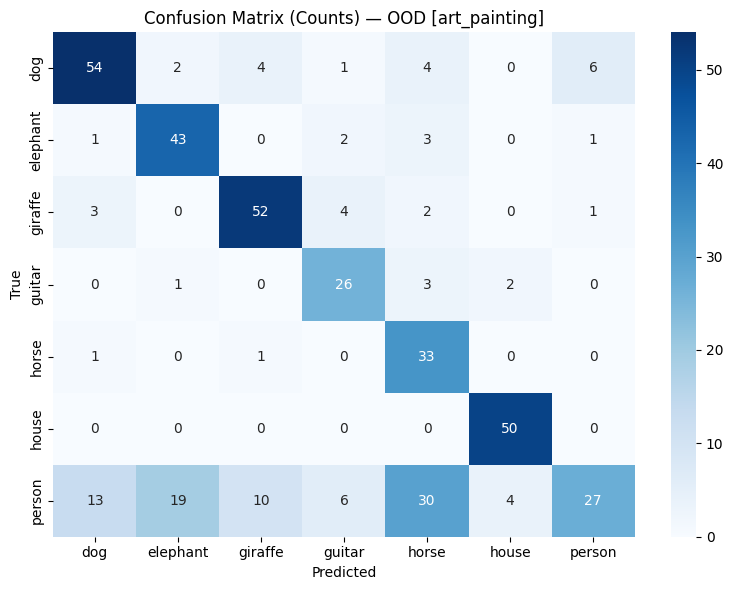

Saved: dann_results/ood_art_cm_row_norm.png


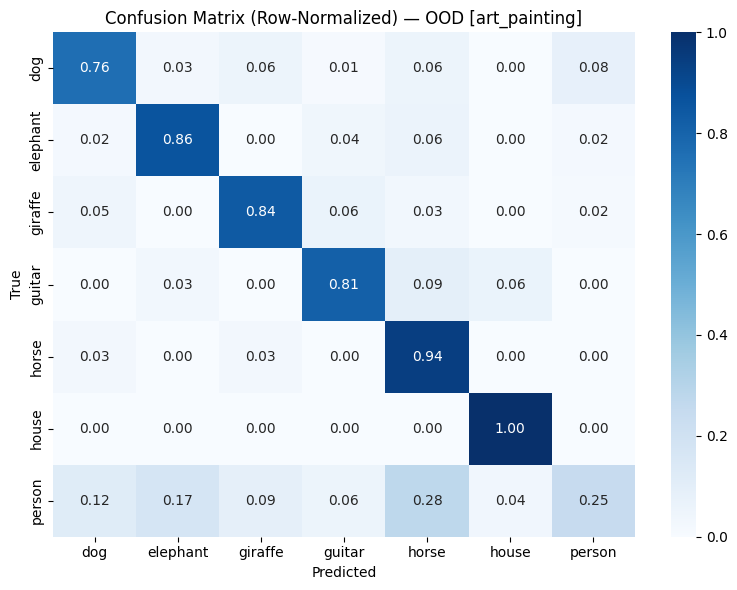

/home/csalt/anaconda3/envs/allm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3718 samples in 0.002s...
[t-SNE] Computed neighbors for 3718 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3718
[t-SNE] Computed conditional probabilities for sample 2000 / 3718
[t-SNE] Computed conditional probabilities for sample 3000 / 3718
[t-SNE] Computed conditional probabilities for sample 3718 / 3718
[t-SNE] Mean sigma: 4.069182
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.510696
[t-SNE] KL divergence after 1000 iterations: 0.960422


/tmp/ipykernel_1799084/451811302.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', C)


Saved: dann_results/tsne_pacs.png


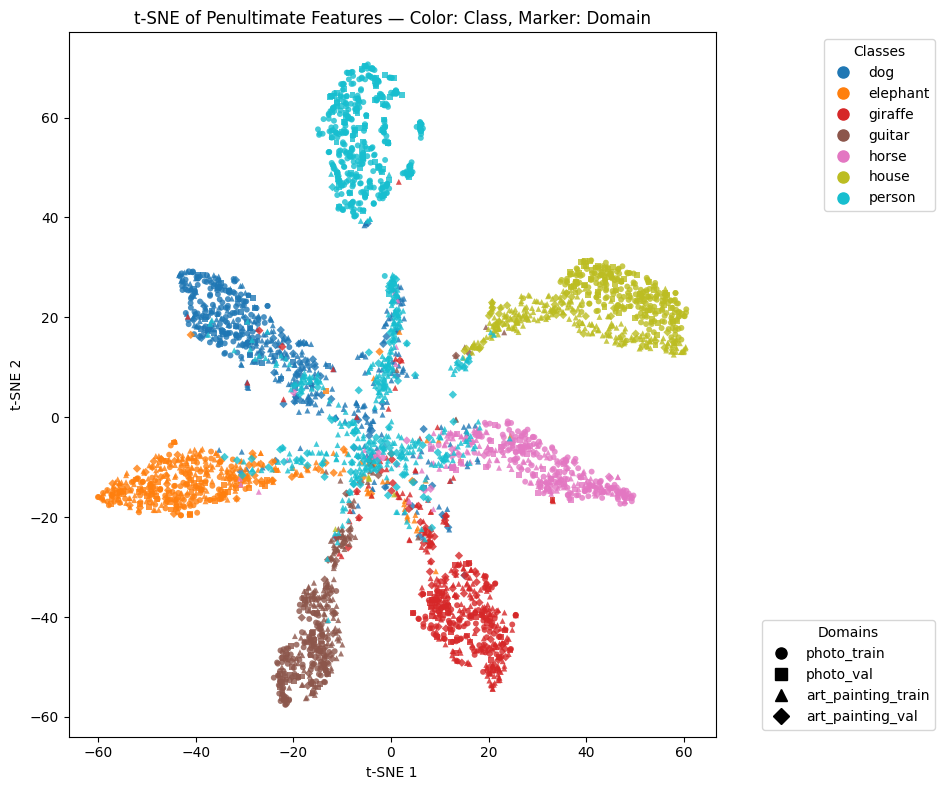

Saved: dann_results/shift_art_minus_photo.png


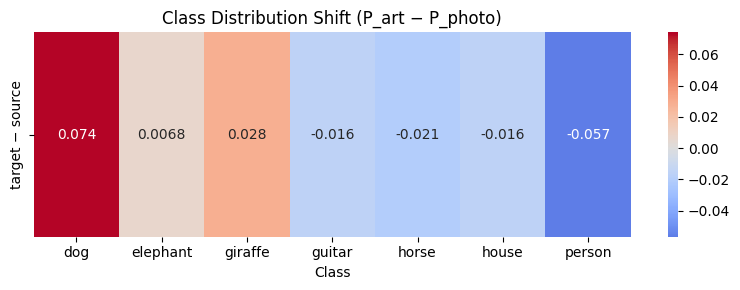

In [44]:
## load the model weights and evaluate ##
model = DANN(num_classes=7)
model.load_state_dict(torch.load("DANN_Model/DANN_photo2art.pth"))
model = model.to(device)

# Create results directory
results_dir = "dann_results"

# 1) OOD evaluation on art_painting
eval_art = evaluate_with_reports(
    model, art_val_loader, device="cuda",
    desc="OOD [art_painting]", show_plots=True, 
    save_dir=results_dir, save_prefix="ood_art"
)

# 2) t-SNE across photo_train, photo_val, art_painting
tsne_out = tsne_penultimate_features(
    model,
    loaders={
        "photo_train": photo_train_loader,
        "photo_val":   photo_val_loader,
        "art_painting_train": art_train_loader,
        "art_painting_val": art_val_loader

    },
    device="cuda",
    max_per_split=None,   # or an int for speed
    save_dir=results_dir,
    save_filename="tsne_pacs.png"
)

# 3) Class-distribution shift: photo_train vs art_painting
shift = plot_class_distribution_shift(
    source_loader=photo_train_loader,
    target_loader=art_train_loader,
    title="Class Distribution Shift (P_art − P_photo)",
    save_dir=results_dir,
    save_filename="shift_art_minus_photo.png"
)

## CDAN ##


In [40]:

from torchvision import models

class CDAN(nn.Module):
    def __init__(self, num_classes=7, disc_hidden=1024,
                 backbone_weights=models.ResNet50_Weights.IMAGENET1K_V2):
        super().__init__()
        # Backbone
        self.backbone = models.resnet50(weights=backbone_weights)
        in_dim = self.backbone.fc.in_features

        # Expose penultimate features
        self.backbone.fc = nn.Identity()

        # Label classifier head (k-way)
        self.classifier = nn.Linear(in_dim, num_classes)

        # NOTE: discriminator now sees the joint (f ⊗ p) of size in_dim * num_classes
        disc_in = in_dim * num_classes
        self.domain_discriminator = nn.Sequential(
            nn.Linear(disc_in, disc_hidden), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(disc_hidden, disc_hidden), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(disc_hidden, 1)  # logits
        )

    def forward(self, x, alpha=0.0):
        """
        Returns: class_logits, domain_logits, features
        - Domain path uses z = f ⊗ softmax(C(f)) (flattened) through a GRL.
        """
        feats = self.backbone(x)                 # [B, d]
        class_logits = self.classifier(feats)    # [B, k]
        probs = torch.softmax(class_logits, dim=1)  # [B, k]

        # joint = f ⊗ p  (outer product per sample)  → [B, d, k] → flatten to [B, d*k]
        joint = torch.bmm(feats.unsqueeze(2), probs.unsqueeze(1))  # [B, d, k]
        joint = joint.view(feats.size(0), -1)                      # [B, d*k]

        rev_joint = grad_reverse(joint, alpha)
        domain_logits = self.domain_discriminator(rev_joint)       # [B, 1]

        return class_logits, domain_logits, feats


In [41]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from itertools import islice
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CDAN(num_classes=7).to(device)

# Losses
ce  = nn.CrossEntropyLoss()        # source label loss
bce = nn.BCEWithLogitsLoss()       # domain loss (binary)

# Optimizer
optimizer = optim.Adam([
    {"params": model.backbone.parameters(),           "lr": 1e-4},
    {"params": model.classifier.parameters(),         "lr": 1e-4},
    {"params": model.domain_discriminator.parameters(),"lr": 1e-4},
])

# Ganin GRL scheduling helper (0 -> 1 over training)
def grl_alpha(progress: float) -> float:
    # progress in [0,1]
    return 2.0 / (1.0 + math.exp(-10.0 * progress)) - 1.0

lambda_d = 0.2
epochs   = 20

@torch.no_grad()
def evaluate_cls(model, loader, desc):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits, _, _ = model(x, alpha=0.0)  # no GRL in eval
        loss = ce(logits, y)
        pred = logits.argmax(1)
        total_loss += loss.item() * x.size(0)
        correct    += (pred == y).sum().item()
        total      += x.size(0)
    return total_loss / total, 100.0 * correct / total

# ===== Track best model =====
best_art_acc = 0.0
save_path = os.path.join(os.getcwd(), "CDAN_photo2art.pth")

for epoch in range(1, epochs + 1):
    model.train()
    running = {"cls": 0.0, "dom": 0.0, "total": 0.0}
    seen = 0

    steps_per_epoch = max(len(photo_train_loader), len(art_train_loader))
    src_iter = iter(photo_train_loader)
    tgt_iter = iter(art_train_loader)

    pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch:02d} [Train]")
    for step in pbar:
        try:
            xs, ys = next(src_iter)
        except StopIteration:
            src_iter = iter(photo_train_loader)
            xs, ys = next(src_iter)

        try:
            xt, _ = next(tgt_iter)
        except StopIteration:
            tgt_iter = iter(art_train_loader)
            xt, _ = next(tgt_iter)

        xs = xs.to(device, non_blocking=True)
        ys = ys.to(device, non_blocking=True)
        xt = xt.to(device, non_blocking=True)

        global_step = (epoch - 1) * steps_per_epoch + step
        total_steps = epochs * steps_per_epoch
        alpha = grl_alpha(global_step / max(1, total_steps - 1))

        # Forward passes
        src_cls_logits, src_dom_logits, _ = model(xs, alpha=alpha)
        _, tgt_dom_logits, _ = model(xt, alpha=alpha)

        # Losses
        loss_cls = ce(src_cls_logits, ys)
        src_dom_t = torch.zeros_like(src_dom_logits)
        tgt_dom_t = torch.ones_like(tgt_dom_logits)

        loss_dom_src = bce(src_dom_logits, src_dom_t)
        loss_dom_tgt = bce(tgt_dom_logits, tgt_dom_t)
        loss_dom = 0.5 * (loss_dom_src + loss_dom_tgt)

        loss = loss_cls + lambda_d * loss_dom

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bs = xs.size(0)
        running["cls"]   += loss_cls.item() * bs
        running["dom"]   += loss_dom.item() * bs
        running["total"] += loss.item()     * bs
        seen += bs

        pbar.set_postfix({
            "CE":   f"{running['cls']/seen:.4f}",
            "Dom":  f"{running['dom']/seen:.4f}",
            "Tot":  f"{running['total']/seen:.4f}",
            "α":    f"{alpha:.2f}"
        })

    # ===== Validation =====
    photo_val_loss, photo_val_acc = evaluate_cls(model, photo_val_loader, "photo_val")
    art_val_loss,   art_val_acc   = evaluate_cls(model, art_val_loader,   "art_val")

    print(f"Epoch {epoch:02d} | "
          f"Train CE: {running['cls']/seen:.4f} | Train Dom: {running['dom']/seen:.4f} | Train Total: {running['total']/seen:.4f} || "
          f"Val Photo: loss {photo_val_loss:.4f}, acc {photo_val_acc:.2f}% || "
          f"Val Art: loss {art_val_loss:.4f}, acc {art_val_acc:.2f}%")

    # ===== Save best model (based on Art val acc) =====
    if art_val_acc > best_art_acc:
        best_art_acc = art_val_acc
        torch.save(model.state_dict(), save_path)
        print(f"** Saved new best model (Art acc={best_art_acc:.2f}%) to {save_path} **")

print(f"Training complete. Best Art validation accuracy: {best_art_acc:.2f}%")


Epoch 01 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, CE=1.0608, Dom=0.6347, Tot=1.1878, α=0.24]


Epoch 01 | Train CE: 1.0608 | Train Dom: 0.6347 | Train Total: 1.1878 || Val Photo: loss 0.3165, acc 97.01% || Val Art: loss 1.2500, acc 57.95%
** Saved new best model (Art acc=57.95%) to /home/csalt/Haider/ATML/ATML-PA 2/CDAN_photo2art.pth **


Epoch 02 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, CE=0.1029, Dom=0.3461, Tot=0.1721, α=0.46]



Epoch 02 | Train CE: 0.1029 | Train Dom: 0.3461 | Train Total: 0.1721 || Val Photo: loss 0.0238, acc 99.70% || Val Art: loss 1.0215, acc 67.24%
** Saved new best model (Art acc=67.24%) to /home/csalt/Haider/ATML/ATML-PA 2/CDAN_photo2art.pth **


Epoch 03 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s, CE=0.0117, Dom=0.2338, Tot=0.0585, α=0.63]


Epoch 03 | Train CE: 0.0117 | Train Dom: 0.2338 | Train Total: 0.0585 || Val Photo: loss 0.0175, acc 99.70% || Val Art: loss 0.9647, acc 69.44%
** Saved new best model (Art acc=69.44%) to /home/csalt/Haider/ATML/ATML-PA 2/CDAN_photo2art.pth **


Epoch 04 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.10it/s, CE=0.0303, Dom=0.5102, Tot=0.1324, α=0.76]


Epoch 04 | Train CE: 0.0303 | Train Dom: 0.5102 | Train Total: 0.1324 || Val Photo: loss 0.0287, acc 99.40% || Val Art: loss 0.8004, acc 75.79%
** Saved new best model (Art acc=75.79%) to /home/csalt/Haider/ATML/ATML-PA 2/CDAN_photo2art.pth **


Epoch 05 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0179, Dom=0.6426, Tot=0.1464, α=0.85]



Epoch 05 | Train CE: 0.0179 | Train Dom: 0.6426 | Train Total: 0.1464 || Val Photo: loss 0.0212, acc 99.10% || Val Art: loss 0.9668, acc 71.88%


Epoch 06 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0081, Dom=0.7397, Tot=0.1560, α=0.90]


Epoch 06 | Train CE: 0.0081 | Train Dom: 0.7397 | Train Total: 0.1560 || Val Photo: loss 0.0281, acc 99.10% || Val Art: loss 1.0747, acc 69.93%


Epoch 07 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, CE=0.0286, Dom=0.6779, Tot=0.1642, α=0.94]


Epoch 07 | Train CE: 0.0286 | Train Dom: 0.6779 | Train Total: 0.1642 || Val Photo: loss 0.0295, acc 99.10% || Val Art: loss 1.0610, acc 74.57%


Epoch 08 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.10it/s, CE=0.0070, Dom=0.6620, Tot=0.1394, α=0.96]


Epoch 08 | Train CE: 0.0070 | Train Dom: 0.6620 | Train Total: 0.1394 || Val Photo: loss 0.0402, acc 99.70% || Val Art: loss 1.0222, acc 68.95%


Epoch 09 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0134, Dom=0.6475, Tot=0.1429, α=0.98]


Epoch 09 | Train CE: 0.0134 | Train Dom: 0.6475 | Train Total: 0.1429 || Val Photo: loss 0.0216, acc 99.10% || Val Art: loss 0.9962, acc 71.15%


Epoch 10 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, CE=0.0069, Dom=0.6297, Tot=0.1328, α=0.99]


Epoch 10 | Train CE: 0.0069 | Train Dom: 0.6297 | Train Total: 0.1328 || Val Photo: loss 0.0189, acc 99.40% || Val Art: loss 1.0579, acc 75.06%


Epoch 11 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.07it/s, CE=0.0205, Dom=0.6811, Tot=0.1567, α=0.99]



Epoch 11 | Train CE: 0.0205 | Train Dom: 0.6811 | Train Total: 0.1567 || Val Photo: loss 0.0646, acc 98.20% || Val Art: loss 1.0410, acc 71.88%


Epoch 12 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0288, Dom=0.6683, Tot=0.1625, α=1.00]


Epoch 12 | Train CE: 0.0288 | Train Dom: 0.6683 | Train Total: 0.1625 || Val Photo: loss 0.0631, acc 98.20% || Val Art: loss 1.1464, acc 68.46%


Epoch 13 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0123, Dom=0.6706, Tot=0.1464, α=1.00]



Epoch 13 | Train CE: 0.0123 | Train Dom: 0.6706 | Train Total: 0.1464 || Val Photo: loss 0.0269, acc 99.40% || Val Art: loss 1.0123, acc 72.86%


Epoch 14 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, CE=0.0041, Dom=0.6748, Tot=0.1391, α=1.00]


Epoch 14 | Train CE: 0.0041 | Train Dom: 0.6748 | Train Total: 0.1391 || Val Photo: loss 0.0368, acc 99.10% || Val Art: loss 1.1891, acc 70.66%


Epoch 15 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s, CE=0.0035, Dom=0.6745, Tot=0.1384, α=1.00]


Epoch 15 | Train CE: 0.0035 | Train Dom: 0.6745 | Train Total: 0.1384 || Val Photo: loss 0.0300, acc 98.80% || Val Art: loss 1.1636, acc 70.66%


Epoch 16 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, CE=0.0017, Dom=0.6768, Tot=0.1371, α=1.00]


Epoch 16 | Train CE: 0.0017 | Train Dom: 0.6768 | Train Total: 0.1371 || Val Photo: loss 0.0336, acc 99.10% || Val Art: loss 1.3498, acc 71.88%


Epoch 17 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0005, Dom=0.6729, Tot=0.1351, α=1.00]



Epoch 17 | Train CE: 0.0005 | Train Dom: 0.6729 | Train Total: 0.1351 || Val Photo: loss 0.0364, acc 99.10% || Val Art: loss 1.4619, acc 72.86%


Epoch 18 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s, CE=0.0021, Dom=0.6782, Tot=0.1377, α=1.00]


Epoch 18 | Train CE: 0.0021 | Train Dom: 0.6782 | Train Total: 0.1377 || Val Photo: loss 0.0765, acc 98.20% || Val Art: loss 1.4044, acc 72.86%


Epoch 19 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.13it/s, CE=0.0073, Dom=0.6819, Tot=0.1437, α=1.00]


Epoch 19 | Train CE: 0.0073 | Train Dom: 0.6819 | Train Total: 0.1437 || Val Photo: loss 0.0346, acc 99.10% || Val Art: loss 1.1873, acc 72.86%


Epoch 20 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, CE=0.0164, Dom=0.6647, Tot=0.1493, α=1.00]


Epoch 20 | Train CE: 0.0164 | Train Dom: 0.6647 | Train Total: 0.1493 || Val Photo: loss 0.0588, acc 98.20% || Val Art: loss 1.1394, acc 70.66%
Training complete. Best Art validation accuracy: 75.79%


/tmp/ipykernel_1799084/2600018037.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CDAN_Model/CDAN_photo2art.pth"))
                    


=== OOD [art_painting] Results ===
Loss: 0.8004 | Acc: 75.79%

              precision    recall  f1-score   support

         dog     0.9216    0.6620    0.7705        71
    elephant     0.6471    0.8800    0.7458        50
     giraffe     0.8125    0.8387    0.8254        62
      guitar     0.7368    0.8750    0.8000        32
       horse     0.4783    0.9429    0.6346        35
       house     0.9423    0.9800    0.9608        50
      person     0.8507    0.5229    0.6477       109

    accuracy                         0.7579       409
   macro avg     0.7699    0.8145    0.7693       409
weighted avg     0.8027    0.7579    0.7570       409

Saved: cdan_results/ood_art_cm_counts.png


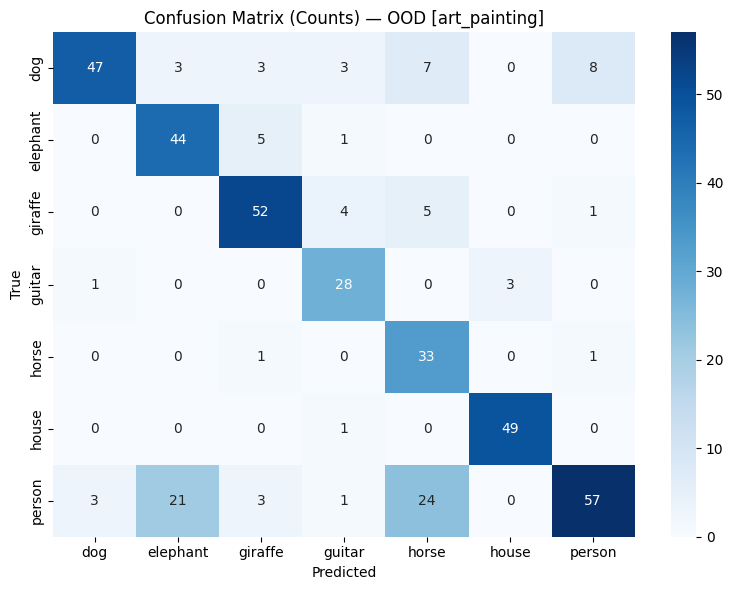

Saved: cdan_results/ood_art_cm_row_norm.png


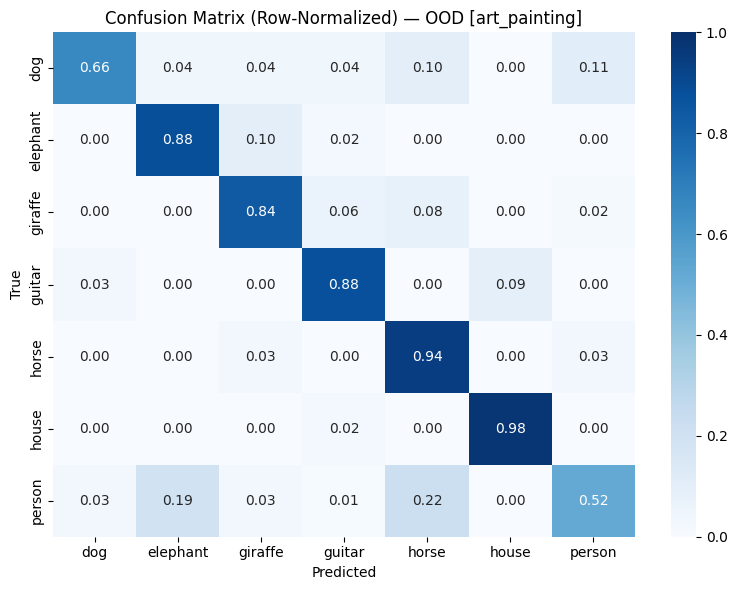

/home/csalt/anaconda3/envs/allm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/csalt/anaconda3/envs/allm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3718 samples in 0.002s...
[t-SNE] Computed neighbors for 3718 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3718
[t-SNE] Computed conditional probabilities for sample 2000 / 3718
[t-SNE] Computed conditional probabilities for sample 3000 / 3718
[t-SNE] Computed conditional probabilities for sample 3718 / 3718
[t-SNE] Mean sigma: 4.964041
[t-SNE] Computed neighbors for 3718 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3718
[t-SNE] Computed conditional probabilities for sample 2000 / 3718
[t-SNE] Computed conditional probabilities for sample 3000 / 3718
[t-SNE] Computed conditional probabilities for sample 3718 / 3718
[t-SNE] Mean sigma: 4.964041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.528587
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.528587
[t-SNE] KL divergence after 1000 iterations: 1.116073
[t-SNE

/tmp/ipykernel_1799084/451811302.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', C)


Saved: cdan_results/tsne_pacs.png


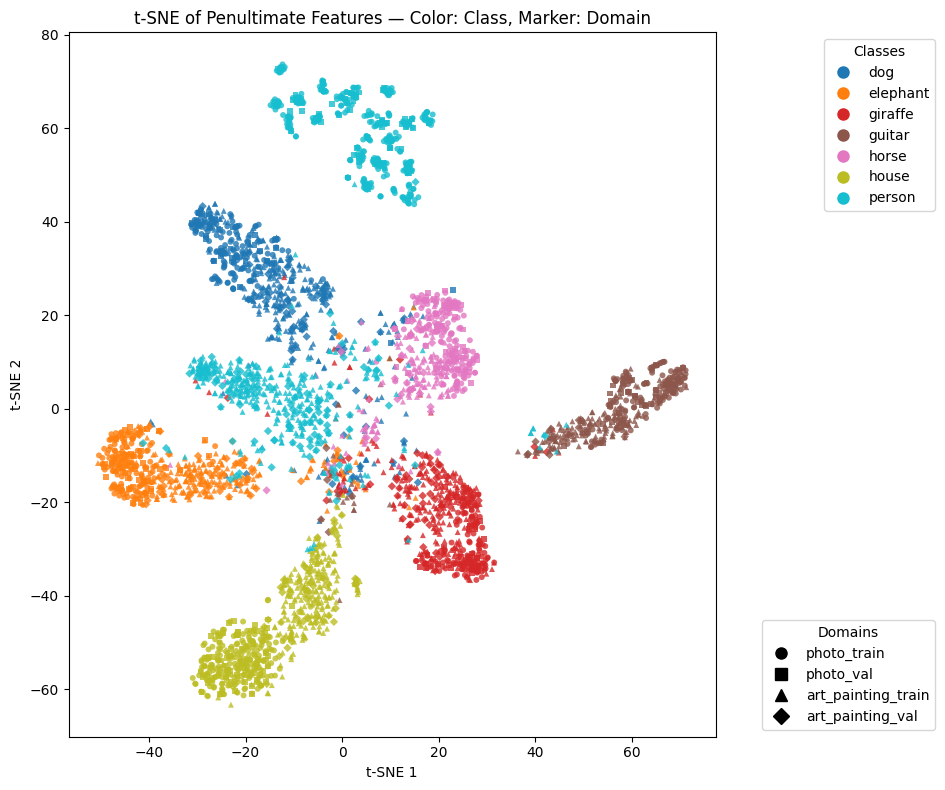

Saved: cdan_results/shift_art_minus_photo.png


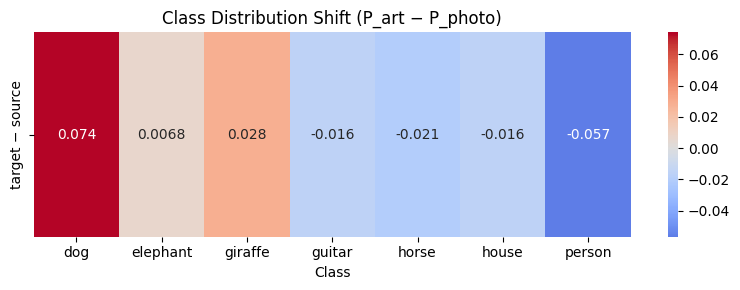

In [43]:
model = CDAN(num_classes=7)
model.load_state_dict(torch.load("CDAN_Model/CDAN_photo2art.pth"))
model = model.to(device)

# Create results directory
results_dir = "cdan_results"

# 1) OOD evaluation on art_painting
eval_art = evaluate_with_reports(
    model, art_val_loader, device="cuda",
    desc="OOD [art_painting]", show_plots=True, 
    save_dir=results_dir, save_prefix="ood_art"
)

# 2) t-SNE across photo_train, photo_val, art_painting
tsne_out = tsne_penultimate_features(
    model,
    loaders={
        "photo_train": photo_train_loader,
        "photo_val":   photo_val_loader,
        "art_painting_train": art_train_loader,
        "art_painting_val": art_val_loader

    },
    device="cuda",
    max_per_split=None,   # or an int for speed
    save_dir=results_dir,
    save_filename="tsne_pacs.png"
)

# 3) Class-distribution shift: photo_train vs art_painting
shift = plot_class_distribution_shift(
    source_loader=photo_train_loader,
    target_loader=art_train_loader,
    title="Class Distribution Shift (P_art − P_photo)",
    save_dir=results_dir,
    save_filename="shift_art_minus_photo.png"
)

## DAN ##

In [45]:
# --- MMD utilities (RBF multi-kernel over pooled embeddings) ---
def _pdist2(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # x: [B, d], y: [B, d] → returns [B, B] with squared Euclidean distances
    x2 = (x * x).sum(dim=1, keepdim=True)          # [B, 1]
    y2 = (y * y).sum(dim=1, keepdim=True)          # [B, 1]
    xy = x @ y.t()                                  # [B, B]
    return x2 + y2.t() - 2.0 * xy

def _rbf_kernel(dist2: torch.Tensor, sigma: float) -> torch.Tensor:
    # K_ij = exp( -||xi - yj||^2 / (2*sigma^2) )
    return torch.exp(-dist2 / (2.0 * (sigma ** 2) + 1e-12))

def mmd_rbf(x: torch.Tensor, y: torch.Tensor, sigmas=(1.0, 2.0, 4.0, 8.0, 16.0)) -> torch.Tensor:
    """
    Biased MMD^2 estimate with multi-kernel RBF.
    x, y: [B, d] pooled embeddings (final feature vectors).
    """
    dist_xx = _pdist2(x, x)
    dist_yy = _pdist2(y, y)
    dist_xy = _pdist2(x, y)

    K_xx = 0.0
    K_yy = 0.0
    K_xy = 0.0
    for s in sigmas:
        K_xx = K_xx + _rbf_kernel(dist_xx, s)
        K_yy = K_yy + _rbf_kernel(dist_yy, s)
        K_xy = K_xy + _rbf_kernel(dist_xy, s)

    # Biased estimator (simple and stable): E[Kxx] + E[Kyy] - 2E[Kxy]
    m = x.size(0)
    n = y.size(0)
    return K_xx.mean() + K_yy.mean() - 2.0 * K_xy.mean()


In [46]:
from torchvision import models
import torch.nn as nn

# --- Model: ResNet-50 backbone + linear head; returns (logits, feats) ---
class ResNet50DAN(nn.Module):
    def __init__(self, num_classes=7,
                 weights=models.ResNet50_Weights.IMAGENET1K_V2):
        super().__init__()
        self.backbone = models.resnet50(weights=weights)
        in_dim = self.backbone.fc.in_features
        # keep avgpool; replace fc with identity to expose pooled 2048-D features
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)          # [B, 2048] (after avgpool)
        logits = self.classifier(feats)   # [B, num_classes]
        return logits, feats
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50DAN(num_classes=7).to(device)

# ensure the *entire* network is trainable
for p in model.parameters():
    p.requires_grad = True  # default True, but explicit per your request

# optimizer over backbone + classifier (no discriminator in DAN)
optimizer = torch.optim.Adam([
    {"params": model.backbone.parameters(),  "lr": 1e-4},
    {"params": model.classifier.parameters(),"lr": 1e-4},
])



In [49]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm

# ===== DAN hyperparameters =====
lambda_mmd = 0.1   # weight for MMD on pooled embeddings (tune 0.05–0.1)
epochs      = 20

ce = nn.CrossEntropyLoss()

# ---- helpers to be robust to your model's forward signature ----
def _forward_logits_feats(model, x):
    """
    Returns (logits, feats) regardless of whether model forward is:
      - model(x, alpha=...) or model(x)
      - returns (logits, feats) or (logits, domain_logits, feats)
    """
    try:
        out = model(x, alpha=0.0)  # works for your previous DANN/CDAN signatures
    except TypeError:
        out = model(x)

    if isinstance(out, (tuple, list)):
        if len(out) == 3:
            logits, _, feats = out
        elif len(out) == 2:
            logits, feats = out
        else:
            logits = out[0]
            feats  = out[-1]
    else:
        raise RuntimeError("Model must return (logits, feats) or (logits, _, feats).")
    return logits, feats

@torch.no_grad()
def evaluate_cls(model, loader, device):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits, _ = _forward_logits_feats(model, x)
        loss = ce(logits, y)
        pred = logits.argmax(1)
        total_loss += loss.item() * x.size(0)
        correct    += (pred == y).sum().item()
        total      += x.size(0)
    return total_loss / total, 100.0 * correct / total

# ===== Track best model =====
best_art_acc = 0.0
save_path = os.path.join(os.getcwd(), "DAN_photo2art.pth")

for epoch in range(1, epochs + 1):
    model.train()
    running = {"cls": 0.0, "mmd": 0.0, "total": 0.0}
    seen_cls = 0
    seen_mmd = 0

    steps_per_epoch = max(len(photo_train_loader), len(art_train_loader))
    src_iter = iter(photo_train_loader)
    tgt_iter = iter(art_train_loader)

    pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch:02d} [Train]")
    for _ in pbar:
        try:
            xs, ys = next(src_iter)
        except StopIteration:
            src_iter = iter(photo_train_loader)
            xs, ys = next(src_iter)

        try:
            xt, _ = next(tgt_iter)
        except StopIteration:
            tgt_iter = iter(art_train_loader)
            xt, _ = next(tgt_iter)

        xs = xs.to(device, non_blocking=True)
        ys = ys.to(device, non_blocking=True)
        xt = xt.to(device, non_blocking=True)

        # ---- Forward ----
        src_logits, feats_s = _forward_logits_feats(model, xs)  # feats_s: [B_s, d]
        _,          feats_t = _forward_logits_feats(model, xt)  # feats_t: [B_t, d]

        # ---- Losses ----
        loss_cls  = ce(src_logits, ys)
        loss_mmd  = mmd_rbf(feats_s, feats_t)   # your MMD utility
        loss      = loss_cls + lambda_mmd * loss_mmd

        # ---- Step ----
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # ---- Logging ----
        bs_s = xs.size(0)
        running["cls"]   += loss_cls.item() * bs_s
        running["total"] += loss.item()     * bs_s
        seen_cls         += bs_s

        mmd_weight = min(xs.size(0), xt.size(0))
        running["mmd"] += loss_mmd.item() * mmd_weight
        seen_mmd       += mmd_weight

        pbar.set_postfix({
            "CE":   f"{running['cls']/max(1,seen_cls):.4f}",
            "MMD":  f"{running['mmd']/max(1,seen_mmd):.4f}",
            "Tot":  f"{running['total']/max(1,seen_cls):.4f}",
        })

    # ===== Validation =====
    photo_val_loss, photo_val_acc = evaluate_cls(model, photo_val_loader, device)
    art_val_loss,   art_val_acc   = evaluate_cls(model, art_val_loader,   device)

    print(f"Epoch {epoch:02d} | "
          f"Train CE: {running['cls']/max(1,seen_cls):.4f} | "
          f"Train MMD: {running['mmd']/max(1,seen_mmd):.4f} | "
          f"Train Total: {running['total']/max(1,seen_cls):.4f} || "
          f"Val Photo: loss {photo_val_loss:.4f}, acc {photo_val_acc:.2f}% || "
          f"Val Art: loss {art_val_loss:.4f}, acc {art_val_acc:.2f}%")

    # ===== Save best model (Art accuracy) =====
    if art_val_acc > best_art_acc:
        best_art_acc = art_val_acc
        torch.save(model.state_dict(), save_path)
        print(f"** Saved new best model (Art acc={best_art_acc:.2f}%) to {save_path} **")

print(f"Training complete. Best Art validation accuracy: {best_art_acc:.2f}%")


Epoch 01 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, CE=0.9988, MMD=0.1769, Tot=1.0166]


Epoch 01 | Train CE: 0.9988 | Train MMD: 0.1769 | Train Total: 1.0166 || Val Photo: loss 0.2407, acc 97.31% || Val Art: loss 1.2229, acc 57.21%
** Saved new best model (Art acc=57.21%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 02 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0927, MMD=0.2266, Tot=0.1155]


Epoch 02 | Train CE: 0.0927 | Train MMD: 0.2266 | Train Total: 0.1155 || Val Photo: loss 0.0304, acc 99.10% || Val Art: loss 1.0297, acc 66.26%
** Saved new best model (Art acc=66.26%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 03 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, CE=0.0098, MMD=0.2293, Tot=0.0328]


Epoch 03 | Train CE: 0.0098 | Train MMD: 0.2293 | Train Total: 0.0328 || Val Photo: loss 0.0197, acc 99.70% || Val Art: loss 1.0507, acc 67.97%
** Saved new best model (Art acc=67.97%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 04 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0055, MMD=0.2175, Tot=0.0273]


Epoch 04 | Train CE: 0.0055 | Train MMD: 0.2175 | Train Total: 0.0273 || Val Photo: loss 0.0180, acc 99.10% || Val Art: loss 1.0072, acc 68.70%
** Saved new best model (Art acc=68.70%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 05 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0048, MMD=0.2035, Tot=0.0252]


Epoch 05 | Train CE: 0.0048 | Train MMD: 0.2035 | Train Total: 0.0252 || Val Photo: loss 0.0191, acc 99.40% || Val Art: loss 0.9528, acc 70.17%
** Saved new best model (Art acc=70.17%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 06 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0083, MMD=0.1970, Tot=0.0281]


Epoch 06 | Train CE: 0.0083 | Train MMD: 0.1970 | Train Total: 0.0281 || Val Photo: loss 0.0332, acc 99.10% || Val Art: loss 0.9818, acc 67.24%


Epoch 07 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0055, MMD=0.1873, Tot=0.0243]


Epoch 07 | Train CE: 0.0055 | Train MMD: 0.1873 | Train Total: 0.0243 || Val Photo: loss 0.0385, acc 99.10% || Val Art: loss 0.9884, acc 69.44%


Epoch 08 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0040, MMD=0.1862, Tot=0.0227]


Epoch 08 | Train CE: 0.0040 | Train MMD: 0.1862 | Train Total: 0.0227 || Val Photo: loss 0.0292, acc 99.10% || Val Art: loss 1.0129, acc 69.19%


Epoch 09 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0039, MMD=0.1802, Tot=0.0220]


Epoch 09 | Train CE: 0.0039 | Train MMD: 0.1802 | Train Total: 0.0220 || Val Photo: loss 0.0395, acc 98.80% || Val Art: loss 0.9985, acc 69.44%


Epoch 10 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, CE=0.0020, MMD=0.1776, Tot=0.0198]


Epoch 10 | Train CE: 0.0020 | Train MMD: 0.1776 | Train Total: 0.0198 || Val Photo: loss 0.0506, acc 97.90% || Val Art: loss 1.0387, acc 69.44%


Epoch 11 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0018, MMD=0.1744, Tot=0.0193]


Epoch 11 | Train CE: 0.0018 | Train MMD: 0.1744 | Train Total: 0.0193 || Val Photo: loss 0.0315, acc 98.50% || Val Art: loss 0.9325, acc 71.39%
** Saved new best model (Art acc=71.39%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 12 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s, CE=0.0019, MMD=0.1723, Tot=0.0192]


Epoch 12 | Train CE: 0.0019 | Train MMD: 0.1723 | Train Total: 0.0192 || Val Photo: loss 0.0289, acc 98.50% || Val Art: loss 0.9838, acc 70.42%


Epoch 13 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0008, MMD=0.1687, Tot=0.0178]


Epoch 13 | Train CE: 0.0008 | Train MMD: 0.1687 | Train Total: 0.0178 || Val Photo: loss 0.0252, acc 98.80% || Val Art: loss 0.9514, acc 71.15%


Epoch 14 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, CE=0.0018, MMD=0.1684, Tot=0.0187]


Epoch 14 | Train CE: 0.0018 | Train MMD: 0.1684 | Train Total: 0.0187 || Val Photo: loss 0.0308, acc 99.10% || Val Art: loss 0.9223, acc 73.11%
** Saved new best model (Art acc=73.11%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 15 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, CE=0.0010, MMD=0.1670, Tot=0.0178]


Epoch 15 | Train CE: 0.0010 | Train MMD: 0.1670 | Train Total: 0.0178 || Val Photo: loss 0.0307, acc 99.10% || Val Art: loss 0.9252, acc 73.11%


Epoch 16 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, CE=0.0008, MMD=0.1651, Tot=0.0174]


Epoch 16 | Train CE: 0.0008 | Train MMD: 0.1651 | Train Total: 0.0174 || Val Photo: loss 0.0344, acc 99.10% || Val Art: loss 0.9577, acc 72.86%


Epoch 17 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0007, MMD=0.1640, Tot=0.0172]


Epoch 17 | Train CE: 0.0007 | Train MMD: 0.1640 | Train Total: 0.0172 || Val Photo: loss 0.0320, acc 98.50% || Val Art: loss 0.8947, acc 75.31%
** Saved new best model (Art acc=75.31%) to /home/csalt/Haider/ATML/ATML-PA 2/DAN_photo2art.pth **


Epoch 18 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, CE=0.0006, MMD=0.1625, Tot=0.0170]


Epoch 18 | Train CE: 0.0006 | Train MMD: 0.1625 | Train Total: 0.0170 || Val Photo: loss 0.0368, acc 98.80% || Val Art: loss 0.9667, acc 73.59%


Epoch 19 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, CE=0.0007, MMD=0.1609, Tot=0.0168]


Epoch 19 | Train CE: 0.0007 | Train MMD: 0.1609 | Train Total: 0.0168 || Val Photo: loss 0.0383, acc 98.80% || Val Art: loss 0.9001, acc 74.33%


Epoch 20 [Train]: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, CE=0.0006, MMD=0.1607, Tot=0.0167]


Epoch 20 | Train CE: 0.0006 | Train MMD: 0.1607 | Train Total: 0.0167 || Val Photo: loss 0.0347, acc 98.80% || Val Art: loss 0.9449, acc 74.33%
Training complete. Best Art validation accuracy: 75.31%


/tmp/ipykernel_1799084/1110419793.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("DAN_Model/DAN_photo2art.pth"))



=== OOD [art_painting] Results ===
Loss: 0.8947 | Acc: 75.31%

              precision    recall  f1-score   support

         dog     0.9091    0.7042    0.7937        71
    elephant     0.7647    0.7800    0.7723        50
     giraffe     0.8475    0.8065    0.8264        62
      guitar     0.5882    0.9375    0.7229        32
       horse     0.4848    0.9143    0.6337        35
       house     0.9200    0.9200    0.9200        50
      person     0.7922    0.5596    0.6559       109

    accuracy                         0.7531       409
   macro avg     0.7581    0.8032    0.7607       409
weighted avg     0.7909    0.7531    0.7555       409

Saved: dan_results/ood_art_cm_counts.png


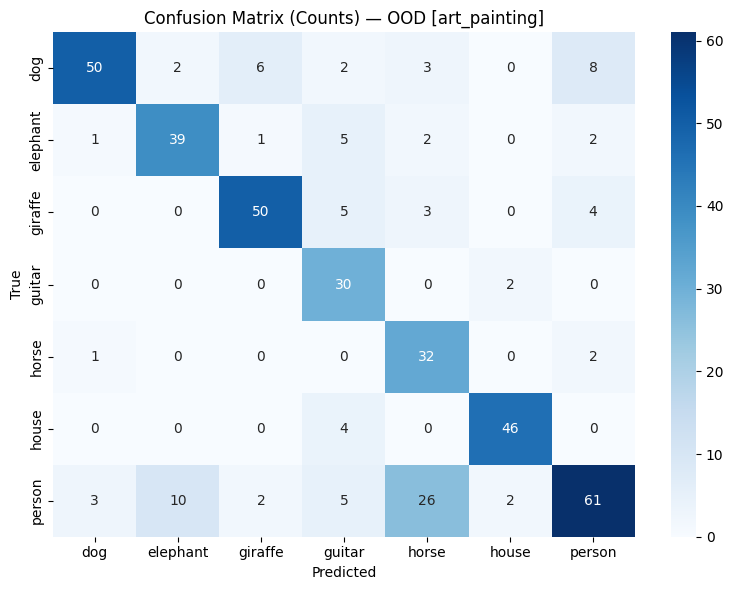

Saved: dan_results/ood_art_cm_row_norm.png


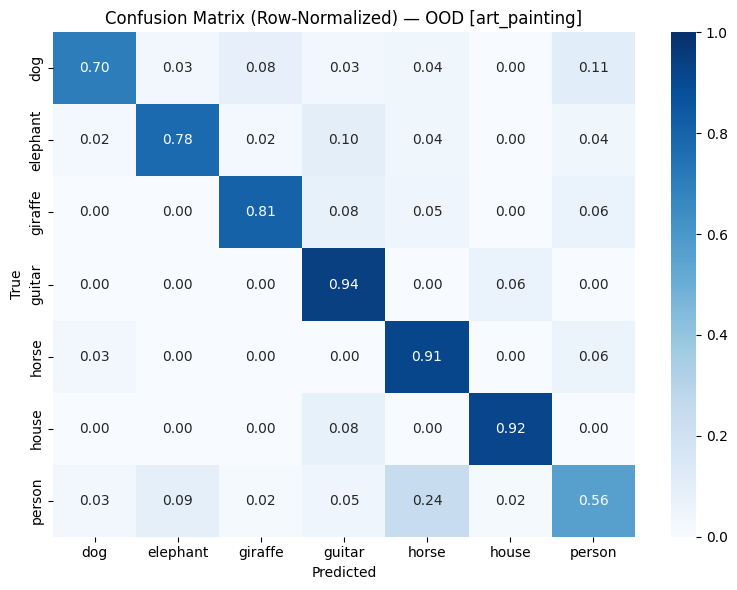

/home/csalt/anaconda3/envs/allm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3718 samples in 0.002s...
[t-SNE] Computed neighbors for 3718 samples in 0.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3718
[t-SNE] Computed conditional probabilities for sample 2000 / 3718
[t-SNE] Computed conditional probabilities for sample 3000 / 3718
[t-SNE] Computed conditional probabilities for sample 3718 / 3718
[t-SNE] Mean sigma: 6.191378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.417488
[t-SNE] KL divergence after 1000 iterations: 1.220583


/tmp/ipykernel_1799084/451811302.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', C)


Saved: dan_results/tsne_pacs.png


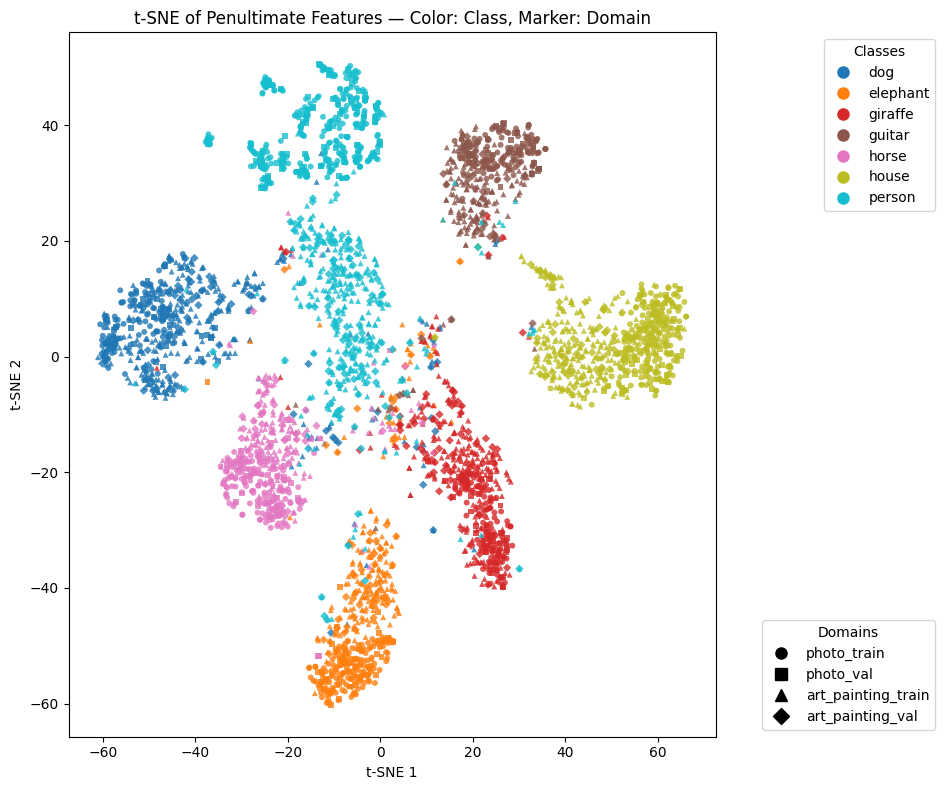

Saved: dan_results/shift_art_minus_photo.png


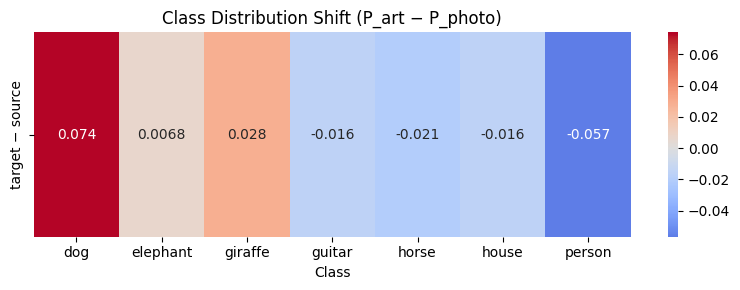

In [50]:
model = ResNet50DAN(num_classes=7)
model.load_state_dict(torch.load("DAN_Model/DAN_photo2art.pth"))
model = model.to(device)

# Create results directory
results_dir = "dan_results"

# 1) OOD evaluation on art_painting
eval_art = evaluate_with_reports(
    model, art_val_loader, device="cuda",
    desc="OOD [art_painting]", show_plots=True, 
    save_dir=results_dir, save_prefix="ood_art"
)

# 2) t-SNE across photo_train, photo_val, art_painting
tsne_out = tsne_penultimate_features(
    model,
    loaders={
        "photo_train": photo_train_loader,
        "photo_val":   photo_val_loader,
        "art_painting_train": art_train_loader,
        "art_painting_val": art_val_loader

    },
    device="cuda",
    max_per_split=None,   # or an int for speed
    save_dir=results_dir,
    save_filename="tsne_pacs.png"
)

# 3) Class-distribution shift: photo_train vs art_painting
shift = plot_class_distribution_shift(
    source_loader=photo_train_loader,
    target_loader=art_train_loader,
    title="Class Distribution Shift (P_art − P_photo)",
    save_dir=results_dir,
    save_filename="shift_art_minus_photo.png"
)